# Preliminaries and Imports
In the following cell, the necessary packages and libraries are imported.

In [1]:
# access to different databases
import pandas_datareader as web
import quandl as quandl
import wrds as wrds

# storage and operations
import pandas as pd
import numpy as np
import datetime
from pathlib import Path
from tqdm import tqdm
import time

# statistics and regression
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from scipy.stats.mstats import winsorize
import quantstats as qs
from scipy.optimize import minimize 

# indicators
import ta as ta
from ta.momentum import KAMAIndicator
from ta.momentum import PercentagePriceOscillator
from ta.momentum import ROCIndicator
from ta.momentum import RSIIndicator
from ta.trend import AroonIndicator
from ta.trend import EMAIndicator
from ta.trend import MACD
from pandas.tseries.offsets import BDay
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from matplotlib.axis import Axis
import matplotlib.dates as mdates 
%matplotlib inline

# warning
import warnings
warnings.filterwarnings("ignore")

# unzipping zip-files
from zipfile import ZipFile

# Data Imports and Preperations

In [2]:
# define an useful path
path = Path('/Users/sebastiansydow/13_Quant_Trading/Group_Project')
# stocks
input_stocks = path / 'permno_selection.csv'
# link betweeen CRSP (permno) and Option Metrics (SECID)
link_permno_secid = path / 'daily_permno_secid_cusip_link.csv.zip'
# glb
glb = path / 'glb_daily.csv'
# model-free implied skewness (MFIS)
mfis = path / 'mfis.csv'
#quandl key
quandl_key = path / 'quandl_key.xlsx'

# import stocks from S&P 500 into a pandas dataframe
df_input_stocks = pd.read_csv(input_stocks)
# glb
df_glb = pd.read_csv(glb)
## rename column
df_glb = df_glb.rename(columns={"id": "permno"})
## transfrom data type
df_glb['date'] = pd.to_datetime(df_glb['date'])
# mfis
df_mfis = pd.read_csv(mfis)
## rename column
df_mfis = df_mfis.rename(columns={"id": "permno"})
## transfrom data type
df_mfis['date'] = pd.to_datetime(df_mfis['date'])

# instantiate zip-file
zip_file = ZipFile(link_permno_secid)
# load linking table
df_link_permno_secid = pd.read_csv(zip_file.open('daily_permno_secid_cusip_link.csv'))

## Daily Stock Returns, Market Capitalization and Value Weights

In [3]:
def retrieve_stock_data(df_input, date_start, date_end, wrds_username):
    # Download stock data
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    
    # create query to load the returns, prices and shares outstanding for S&P 500 companies from 1999/01
    sql_wrds = """
            select distinct date, 
                            permno,
                            cusip, 
                            ret, 
                            abs(prc) as prc, 
                            shrout,
                            abs(prc)*shrout/1000 as mktval
            from crsp.dsf 
            where permno in %(permno)s and date>=%(start)s and date<=%(end)s
            order by date
            """

    # define the parameters, i.e. only those companies (permno), which were part of the S&P 500
    # in the timeframe 2000/01 until 2020/12
    params = {}
    params['start'] = date_start
    params['end'] = date_end
    params['permno'] = tuple(df_input.permno.unique().astype(str))

    # retrieve the data from wrds
    df_stock_data = db.raw_sql(sql_wrds, params = params)

    # change type of entries in the columns start and ending
    df_stock_data['date']  = pd.to_datetime(df_stock_data['date'])
    
    # shift market_val by 1 day
    df_stock_data.loc[:,'mktval_shifted'] = df_stock_data.groupby(['permno'])['mktval'].shift(1)
    
    # dropna
    df_stock_data.dropna(inplace=True)
    
    # calculate weight of each stock on each day
    ## dataframe with total market value on each day
    df_ttl_mkcap = df_stock_data[['date', 'mktval_shifted']].groupby('date').sum().rename(columns={"mktval_shifted": "ttl_mktval"})
    ## merge with df_stock_data
    df_stock_data = pd.merge(df_stock_data, df_ttl_mkcap, how='left', on=['date'])
    ## calculate weightage
    df_stock_data['weightage_pct'] =  df_stock_data['mktval_shifted'] / df_stock_data["ttl_mktval"]
    ## drop columns
    df_stock_data.drop(columns = {'shrout', 'mktval', 'mktval_shifted', 'ttl_mktval'}, inplace = True)
    
    return df_stock_data.sort_values(by=['date']).reset_index(drop=True)

## Fama-French-Factors

In [4]:
def download_ffm(date_start, date_end):
    # start of time period 
    startdt = datetime.datetime(int(date_start[:4]),
                                int(date_start[5:7]),
                                int(date_start[8:]))
    
    # end of time period                            
    enddt = datetime.datetime(int(date_end[:4]),
                              int(date_end[5:7]),
                              int(date_end[8:]))

    # define which dataset are to be downloaded
    d1 = web.DataReader('F-F_Research_Data_Factors_daily','famafrench',start=startdt, end=enddt)
    d2 = web.DataReader('F-F_Momentum_Factor_daily','famafrench',start=startdt, end=enddt)

    # key is 0 -> get returns data
    # divide by 100 to get the returns
    df_ff_3factor = d1[0]/100

    # add momentum factor with an outer-join
    # outer-join: keep all data -> union
    df_ff_4factor = df_ff_3factor.join(d2[0]/100, how = 'outer')

    # reset index for merge later
    df_ff_4factor = df_ff_4factor.reset_index()

    # change columns to be small letters and get rid of white-spaces
    df_ff_4factor.columns = [z.lower().strip() for z in df_ff_4factor.columns]

    # rename column
    df_ff_4factor.rename(columns = {'mkt-rf':'mktrf'}, inplace = True)

    # change order of dataframe
    df_ff_4factor = df_ff_4factor.loc[:,['date', 'mktrf', 'smb', 'hml', 'mom', 'rf']]
                              
    return df_ff_4factor

## Quandl Data

### Crude Oil Prices
- [WTI Spot Price](https://data.nasdaq.com/data/EIA/PET_RWTC_D-cushing-ok-wti-spot-price-fob-daily)
- More Info, see [here](https://ycharts.com/indicators/wti_crude_oil_spot_price)

### Treasury Yields
- [US Treasury Yields](https://data.nasdaq.com/data/USTREASURY/YIELD-treasury-yield-curve-rates)

### Gold
- [LBMA/GOLD](https://data.nasdaq.com/data/LBMA/GOLD-gold-price-london-fixing)

In [5]:
def get_quandl_data(quandl_key):
    # retrieve quandl key
    temp = pd.read_excel(quandl_key)
    # configure quandl
    quandl.ApiConfig.api_key = temp.iloc[0,0]
    
    # Crude Oil
    df_crude_oil = quandl.get("EIA/PET_RWTC_D")
    # calculate daily returns
    df_crude_oil = df_crude_oil.pct_change(1)
    # reset_index
    df_crude_oil.reset_index(inplace=True)
    # rename column
    df_crude_oil.rename(columns={"Value": "ret_crude_oil", "Date": "date"}, inplace=True)
    
    # Treasury Yields
    df_treasury_yield = quandl.get("USTREASURY/YIELD")
    # drop columns
    df_treasury_yield.drop(labels=['1 MO', '2 MO', '3 MO', '6 MO', '2 YR', '3 YR', '5 YR', '7 YR', '20 YR', '30 YR'], axis=1, inplace=True)
    # calculate difference between 10year yield and 1year yield
    df_treasury_yield['yield_dif_10y_1y'] = df_treasury_yield['10 YR'] - df_treasury_yield['1 YR']
    # drop columns
    df_treasury_yield.drop(labels=['1 YR', '10 YR'], axis=1, inplace=True)
    # reset_index
    df_treasury_yield.reset_index(inplace=True)
    # rename column
    df_treasury_yield.rename(columns={"Date": "date"}, inplace=True)
    
    # Gold
    df_gold = quandl.get("LBMA/GOLD")
    # drop columns
    df_gold.drop(labels=['USD (PM)','GBP (AM)', 'GBP (PM)', 'EURO (AM)', 'EURO (PM)'], axis=1, inplace=True)
    # calculate daily returns
    df_gold = df_gold.pct_change(1)
    # reset_index
    df_gold.reset_index(inplace=True)
    # rename column
    df_gold.rename(columns={"USD (AM)": "ret_gold", "Date": "date"}, inplace=True)
    
    return df_crude_oil, df_treasury_yield, df_gold

## Exchange Rates
- [Exchange Rates ST. Louis FRED](https://fred.stlouisfed.org/categories/15)
- [Nominal Emerging Market Economies U.S. Dollar Index](https://fred.stlouisfed.org/series/DTWEXEMEGS), only available from 2006 onwards
- [Real Emerging Market Economies Dollar Index](https://fred.stlouisfed.org/series/RTWEXEMEGS), only available from 2006 onwards

In [6]:
def get_fx_data(symbol, start_date):
    # get data
    df_fx = data.DataReader(symbol, 'fred', start_date)
    # calculate daily returns
    df_fx = df_fx.pct_change(1)
    # reset index
    df_fx.reset_index(inplace=True)
    # rename
    df_fx.rename(columns={'DATE': 'date', symbol: 'fx_rates'}, inplace=True)
    
    return df_fx

## Calculate Excess Return

In [7]:
def calc_excess_return(df, minuend, subtrahend):
    # calculate excess return
    df['excess_return'] = df[minuend]-df[subtrahend]
    return df

## Perfrom Data Preparation 

In [8]:
def data_prep(df_input, date_start, date_end, df_link, wrds_username, minuend, subtrahend, quandl_key):

    ## retrieve data
    df_stock_data = retrieve_stock_data(df_input=df_input_stocks, 
                                        date_start=date_start, 
                                        date_end=date_end, 
                                        wrds_username=wrds_username)
    
    # change type of entries in the columns date
    df_link['date']  = pd.to_datetime(df_link['date'])
    
    ## merge with cusip
    df_stock_data = pd.merge(df_stock_data, df_link.loc[:,['permno', 'date', 'secid']], how = "left", on = ['permno','date'])
    
    
    # Download Fama-French Factors
    df_ffm = download_ffm(date_start=date_start, date_end=date_end)
    
    ## merge stock data with ffm
    # merge with ff-4-factors
    df_stocks_factors = pd.merge(df_stock_data, df_ffm, how='inner', on=['date'])
    
    # calculate excess return
    df_stocks_factors  = calc_excess_return(df=df_stocks_factors, minuend=minuend, subtrahend=subtrahend)
    
    # get quandl data
    df_crude, df_yields, df_gold = get_quandl_data(quandl_key=quandl_key)
    ## merge with stock data
    df_stocks_factors = pd.merge(df_stocks_factors, df_crude, how='left', on=['date'])
    df_stocks_factors = pd.merge(df_stocks_factors, df_yields, how='left', on=['date'])
    df_stocks_factors = pd.merge(df_stocks_factors, df_gold, how='left', on=['date'])
    
    return df_stocks_factors

In [9]:
df_prepared = data_prep(df_input=df_input_stocks,
                        date_start='1999-01-01',
                        date_end='2019-12-31',
                        df_link=df_link_permno_secid,
                        wrds_username='sebastiansydow',
                        minuend='ret',
                        subtrahend='rf', 
                        quandl_key=quandl_key)

Loading library list...
Done


In [10]:
df_prepared

,date,permno,cusip,ret,prc,weightage_pct,secid,mktrf,smb,hml,mom,rf,excess_return,ret_crude_oil,yield_dif_10y_1y,ret_gold
0,1999-01-05,10874.0,11704310,0.018519,24.062500,0.001989,102386.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.018329,-0.030596,0.18,-0.004337
1,1999-01-05,47466.0,65011110,0.030965,35.375000,0.005459,108117.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.030775,-0.030596,0.18,-0.004337
2,1999-01-05,47626.0,12611710,0.000000,40.375000,0.006508,102548.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,-0.000190,-0.030596,0.18,-0.004337
3,1999-01-05,48486.0,51280710,0.328947,25.250000,0.000640,106808.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.328757,-0.030596,0.18,-0.004337
4,1999-01-05,51369.0,88077010,0.083086,45.625000,0.003107,110952.0,0.0110,-0.0073,-0.0009,-0.0097,0.00019,0.082896,-0.030596,0.18,-0.004337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264092,2019-12-31,24205.0,65339F10,0.003606,242.160004,0.041459,104560.0,0.0028,-0.0001,0.0012,-0.0047,0.00007,0.003536,-0.008433,0.33,0.007608
264093,2019-12-31,25320.0,13442910,0.003452,49.419998,0.005214,102660.0,0.0028,-0.0001,0.0012,-0.0047,0.00007,0.003382,-0.008433,0.33,0.007608
264094,2019-12-31,26825.0,48783610,0.005525,69.160004,0.008247,106638.0,0.0028,-0.0001,0.0012,-0.0047,0.00007,0.005455,-0.008433,0.33,0.007608
264095,2019-12-31,18411.0,84258710,0.005684,63.700001,0.023351,110337.0,0.0028,-0.0001,0.0012,-0.0047,0.00007,0.005614,-0.008433,0.33,0.007608


# Estimation of $\beta$-Factors

In [11]:
def estimate_betas(df, window_size, factors, period='daily'):
    # identify all companies (permnos) in the dataframe
    permnos = df.permno.unique()
    # loop over all permnos and perform ols regression
    for permno in tqdm(range(len(permnos))):
        # define dataframe only with current permno
        df_current_permno = df[df['permno'] == permnos[permno]]
        # only perform OLS for stocks with more than 252 observations
        if len(df_current_permno) > window_size:
            # dependent variable
            Y = df_current_permno['excess_return']
            # independent variable
            X = df_current_permno[factors]
            # define constant
            X_constant = sm.add_constant(X)
            # define model
            rol_ols_model = RollingOLS(endog=Y, exog=X_constant, window=window_size)
            # fitting
            # print('Fitting rolling OLS model for permno #', permno, ' from', len(permnos))
            results = rol_ols_model.fit()
            # parameters
            if permno == 0:
                df_params = results.params
            else:
                df_params = pd.concat([df_params, results.params])

    # rename columns
    for col in factors:
        df_params.rename(columns={col: col+str('_beta')}, inplace=True)
    # df_params.rename(columns = {'mktrf':'beta1', 'smb':'beta2', 'hml':'beta3', 'mom': 'beta4'}, inplace = True)
    # merge with df_all by index
    print('Merging the dataframes...')
    df_betas = pd.merge(df, df_params, how='left', left_index=True, right_index=True, suffixes=[None, None])
    print('Merging completed.')
    
    if period == 'daily':
        df_betas.dropna(inplace=True)
        df_betas = df_betas.reset_index(drop=True)
        return df_betas
    
    if period == 'monthly':
        # add '_factor' to the entries in list factors
        ls_factors_betas = [factors[i] + str('_beta') for i in list(range(len(factors)))]
        # create a temporary copy of df_betas
        cols2copy=['permno', 'date', 'const']+ls_factors_betas
        df_temp = df_betas[cols2copy].copy()
        #df_temp = df_betas[['permno', 'date', 'const', 'beta1', 'beta2', 'beta3', 'beta4']].copy()

        # add necessary columns for group by
        df_temp['year'] = df_temp['date'].dt.year
        df_temp['month'] = df_temp['date'].dt.month
        # group dataframe and select last row 
        df_temp = df_temp.groupby(['permno','year', 'month']).tail(n=1)
        
        # rename columns to indicate that those are the betas of the end of each month
        for col in cols2copy[2:]:
            df_temp.rename(columns={col: col+str('_eom')}, inplace=True)
        # df_temp.rename(columns = {'const':'const_eom', 'beta1':'beta1_eom', 'beta2':'beta2_eom', 'beta3':'beta3_eom', 'beta4':'beta4_eom'}, inplace = True)
        # merge with df_betas
        df_betas_monthly = pd.merge(df_betas, df_temp, how='left', on=['date', 'permno'])
        # forward fill estimaed beta factors to assume that they stay constant for the next month until the last day
        gb = df_betas_monthly.groupby('permno')
        cols_eom = cols2copy[2:]
        cols_eom = [cols_eom[i] + str('_eom') for i in list(range(len(cols_eom)))]
        for var in cols_eom:
            df_betas_monthly[var] = gb[var].ffill()
        
        # drop daily betas
        #df_betas_monthly.drop(columns = {'const', 'beta1', 'beta2', 'beta3', 'beta4', 'year', 'month'}, inplace = True)
        df_betas_monthly.drop(['const', 'year', 'month'] + ls_factors_betas + factors, axis = 1, inplace=True)
        # drop nas
        df_betas_monthly.dropna(inplace=True)

        # reset index of df
        df_betas_monthly = df_betas_monthly.reset_index(drop=True)
        
        return df_betas_monthly

In [12]:
factors = ['mktrf', 'smb', 'hml', 'mom', 'ret_crude_oil', 'yield_dif_10y_1y', 'ret_gold']

df_betas = estimate_betas(df=df_prepared, window_size=252, factors=factors, period='monthly')

100%|██████████| 50/50 [01:29<00:00,  1.79s/it]


Merging the dataframes...
Merging completed.


# Plotting of Return

In [13]:
# define a function to calculate the valued weighted average
def weighted_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [14]:
def plot_benchmark_performance(df, column_ret, column_weight):
    # calculate benchmark performance on each day
    df_plot = (df.groupby(['date']).apply(weighted_avg, column_ret, column_weight)+1)
    df_plot.iloc[0] = df_plot.iloc[0] * 100
    
    # size of the plot
    fig, ax = plt.subplots(1, 1, figsize=(8,8))

    # define the spacing on the x-axis
    ## major ticks every 4 years
    major_ticks_years = mdates.YearLocator(4)  
    Axis.set_major_locator(ax.xaxis, major_ticks_years) 
    ## Minor ticks every year 
    minor_ticks_year = mdates.YearLocator(1)
    Axis.set_minor_locator(ax.xaxis, minor_ticks_year)

    # title
    plt.title(r"Value-Weighted Excess-Return of the Benchmark-Portfolio")

    # format the date type to year on the x-axis
    ax.format_xdata = mdates.DateFormatter('% m')

    # 9/11
    ax.annotate('9/11', xy=('2001-09-11 00:00:00', 120), xytext=(15, 15), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2001-09-11'), color='r', linestyle='--', lw=1)

    # bankruptcy Lehman 
    ax.annotate('Bankruptcy Lehman Brothers', xy=('2008-09-15 00:00:00', 90), xytext=(15, 15), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2008-09-15'), color='r', linestyle='--', lw=1)

    # covid
    ax.annotate('Covid-19', xy=('2020-03-16 00:00:00', 350), xytext=(-60, 5), 
                textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    ax.axvline(x=pd.to_datetime('2020-03-16'), color='r', linestyle='--', lw=1)

    # define start and end of x-axis
    ax.set_xlim(min(df['date']), max(df['date']))

    # define labels of x- and y-axis
    ax.set(xlabel="Date",
           ylabel="Performance in % (Value-Weighted Mean of Benchmark Portfolio)")

    ax.plot(df_plot.cumprod(), label="Excess Return Benchmark")
    ax.legend(loc="upper left")
    # df_plot.cumprod().plot(figsize=(10,10))
    
    # quant_stats
    # qs.reports.html(df_plot.cumprod())

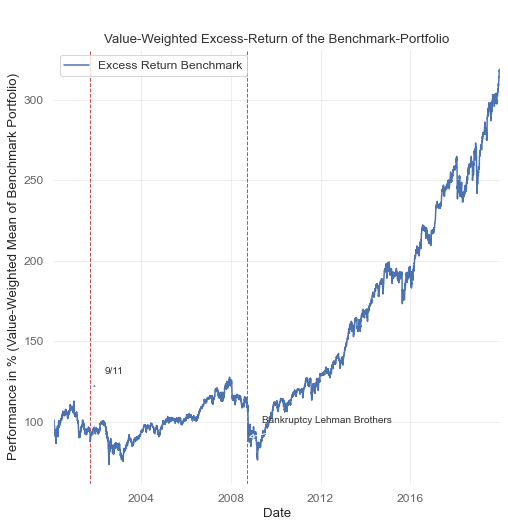

In [15]:
plot_benchmark_performance(df=df_betas, column_ret='excess_return', column_weight='weightage_pct')

# Option-Implied Data and Option Metrics
## GLB and MFIS

In [16]:
# merge data with glb
df_stocks_betas_options = pd.merge(df_betas, df_glb, how="left", on=['permno', 'date'])
# merge data with mfis
df_stocks_betas_options = pd.merge(df_stocks_betas_options, df_mfis, how='left', on=['permno', 'date'])

### Average Volatility [AIV] of all OTM Call and Put Options and SKEW

In [17]:
def retrieve_option_metrics(df, start_year, end_year, days, delta_otm_put, delta_atm_call, delta_otm_put2, delta_atm_call2, wrds_username):
    
    ## establish WRDS connection
    db = wrds.Connection(wrds_username=wrds_username)
    
    # define the parameters
    params = {}
    params['secids'] = tuple(df.secid.unique())
    params['days'] = days
    params['delta_otm_put'] = delta_otm_put
    params['delta_atm_call'] = delta_atm_call
    params['delta_otm_put2'] = delta_otm_put2
    params['delta_atm_call2'] = delta_atm_call2

    # define the sql query
    sql = '''
    select a.date, a.secid, a.iv-b.iv as skew1, c.iv, (g.iv-v.iv)/a.iv as skew2 from 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_atm_call)s) as a, 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_otm_put)s) as b, 

    (select date, secid, AVG(impl_volatility) as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and abs(delta)<=%(delta_atm_call)s
    group by date, secid) as c,
    
    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_otm_put2)s) as g, 

    (select date, secid, impl_volatility as iv 
    from optionm.vsurfd%(year)s
    where secid in %(secids)s and days = %(days)s and delta=%(delta_atm_call2)s) as v

    where a.date= b.date and a.secid = b.secid 
    and a.date = c.date and a.secid = c.secid
    and a.date = g.date and a.secid = g.secid
    and a.date = v.date and a.secid = v.secid
    '''
    # retrieve data for 1999
    params['year'] = start_year
    df_optiondata = db.raw_sql(sql, params = params)

    # append data for each year from 2000 to 2020
    for y in tqdm(range(start_year+1,end_year)):
        # print('Processing year ', y)
        # set parameter for the year
        params['year'] = y
        df_optiondata = pd.concat([df_optiondata, db.raw_sql(sql, params = params)])
        
    return df_optiondata

In [18]:
df_option_metrics = retrieve_option_metrics(df=df_stocks_betas_options,
                                            start_year=1999,
                                            end_year=2020,
                                            days=30,
                                            delta_otm_put=-10,
                                            delta_atm_call=50,
                                            delta_otm_put2=-25,
                                            delta_atm_call2=25,
                                            wrds_username="sebastiansydow")

# change type of entries in the column data
df_option_metrics.loc[:,'date'] = pd.to_datetime(df_option_metrics.loc[:,'date'])

# merge optiondata and stockdata
df_stocks_betas_options = pd.merge(df_stocks_betas_options, df_option_metrics, how='left', on=['secid', 'date'])

Loading library list...
Done


100%|██████████| 20/20 [04:46<00:00, 14.34s/it]


# Data Cleaning

## Delete Columns with many NaNs

In [19]:
def count_nan(df):
    # Count NaN
    df_count_nan = df.isna().sum().reset_index(name="Count NaN")
    # Rename column
    df_count_nan = df_count_nan.rename(columns={"index": "Column"})
    # Plot
    df_count_nan.plot.bar(x='Column', 
                          y='Count NaN', 
                          rot=45, 
                          figsize=(16,6), 
                          title="Count NaN per Column")

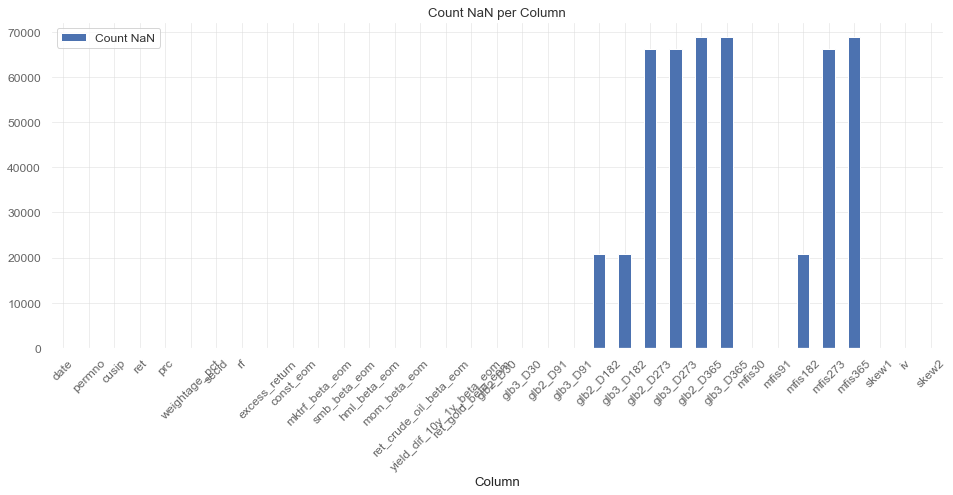

In [20]:
count_nan(df=df_stocks_betas_options)

In [21]:
# drop columns with many nas
df_stocks_betas_options.drop(['glb2_D182', 
                              'glb3_D182', 
                              'glb2_D273', 
                              'glb3_D273', 
                              'glb2_D365', 
                              'glb3_D365',
                              'mfis182',
                              'mfis273', 
                              'mfis365'], inplace=True, axis=1)

## Multicollinearity

In [22]:
def corrmatrix_heatmap(df, columns):
    
    X = df[columns]

    # Compute the correlation matrix
    corrMatrix = X.corr()

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    sns.heatmap(corrMatrix, annot=True)
    # plt.savefig('corrMatrix_heatmap.jpeg', dpi=200, format='jpeg')

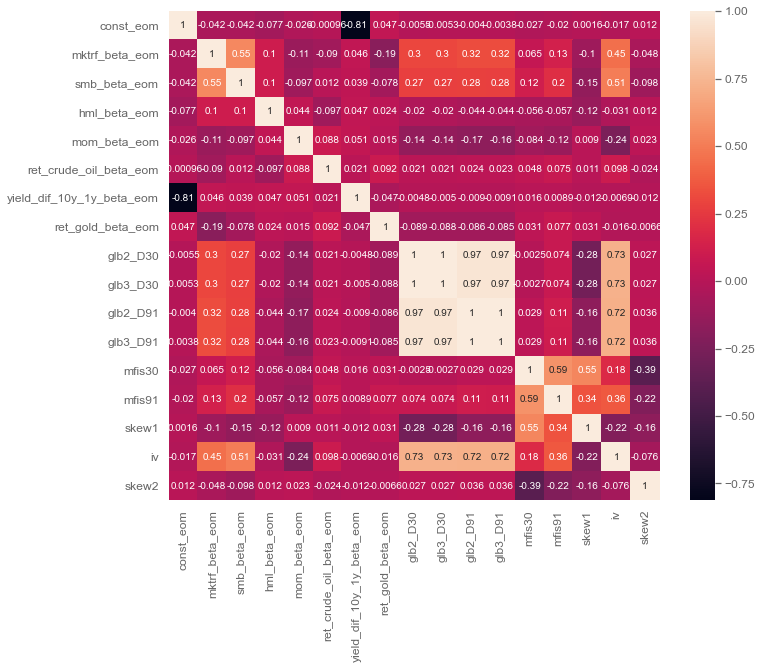

In [23]:
# define columns to calculate pearson correlation coefficient for
idx = list(df_stocks_betas_options.columns).index("excess_return")
columns = list(df_stocks_betas_options.columns)[idx+1:]

# execute function
corrmatrix_heatmap(df=df_stocks_betas_options, columns=columns)

In [24]:
# drop columns
df_stocks_betas_options.drop(['glb2_D30', 
                              'glb3_D30', 
                              'glb2_D91', 
                              'glb3_D91',
                              'mfis30'], inplace=True, axis=1)

## Code for Normalization and Rolling Window regression

In [25]:
def train_test_split_sorted(df,date_of_split, dates):   
    
    date_of_split = pd.to_datetime(date_of_split)
    X_train = df[(df["date"] <= date_of_split) & (df['date'] > pd.datetime(1999, 12, 31))]
    X_test = df[(df["date"] > date_of_split) & (df['date'] < pd.datetime(2020, 1, 1))]
    
    X_train = X_train.sort_values(by=['date','permno'])
    X_test = X_test.sort_values(by=['date','permno'])

    return X_train,X_test

In [26]:
df_stocks_betas_options.loc[:,'date'] = pd.to_datetime(df_stocks_betas_options.loc[:,'date'])


train,test = train_test_split_sorted(df=df_stocks_betas_options,
                                     date_of_split=pd.datetime(2012, 12, 31),
                                     dates=df_stocks_betas_options.date)

In [27]:
def technicals_rock(df_a):
    
    KAMA = KAMAIndicator(close = df_a["prc"],window = 10,pow1 = 2, pow2 = 30)
    PPO = PercentagePriceOscillator(close = df_a["prc"],window_slow = 26, window_fast = 12, window_sign = 9)
    ROCI = ROCIndicator(close=df_a["prc"],window=12)
    RSI = RSIIndicator(close=df_a["prc"],window = 14)
    EMA14 = EMAIndicator(close = df_a["prc"],window = 14)
    EMA25 = EMAIndicator(close = df_a["prc"],window = 25)
    MACD_ind = MACD(close = df_a["prc"],window_slow = 26,window_fast = 12,window_sign=9)
    Aroon = AroonIndicator(close = df_a["prc"],window = 25)
    
    df_a = df_a.assign(    
    KAMA = KAMA.kama(),
    PPO = PPO.ppo_signal(),
    ROCI = ROCI.roc(),
    RSI = RSI.rsi(),
    EMA14 = EMA14.ema_indicator(),
    EMA25 = EMA25.ema_indicator(),
    MACD = MACD_ind.macd_signal(),
    AroonInd = Aroon.aroon_indicator()
    )
    
    return df_a

In [28]:
def process(df,columns):
    df_scaled = df.copy()

    df_scaled = df_scaled.fillna(method='ffill',limit=30,inplace=False)
    df_scaled = df_scaled.dropna()
    
    for column in columns:
        df_scaled[column] = (df_scaled[column] - df_scaled[column].mean())  / df_scaled[column].std()
        df_scaled.loc[:,column] = winsorize(df_scaled.loc[:,column], limits=0.03).data
                                                                     
    df_scaled.loc[:,'fret1d'] = df_scaled.groupby(['permno'])['ret'].shift(-1)
    
    df_scaled = df_scaled.dropna()
    
    return df_scaled

In [29]:
columns2norm = ['skew1', 'skew2', 'iv', 'KAMA','PPO','RSI'] #vrp

train = process(technicals_rock(train),columns2norm)
test = process(technicals_rock(test),columns2norm)

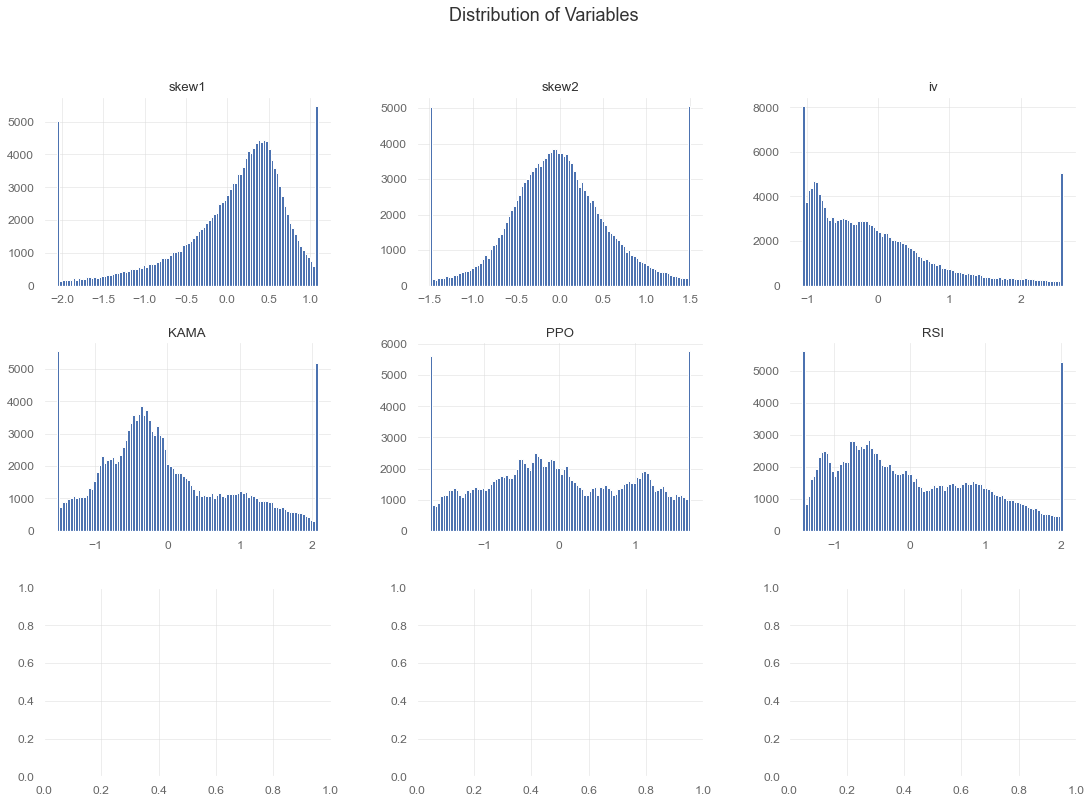

In [30]:
cols = ['skew1', 'skew2', 'iv', 'KAMA','PPO','RSI' ]#,'vrp', 'AroonInd']
fig, axs = plt.subplots(3,3)
fig.set_size_inches(18.5, 12.5, forward=True)
fig.suptitle('Distribution of Variables', fontsize=18)

for i,el in enumerate(cols):
    a = train.hist(el, ax=axs.flatten()[i],bins=100)


In [31]:
def Rolling_Forest(data,predictors,target,window,params):

# First we form the window 
    start_window = data.date.min()
    end_window = data.date.min() + BDay(window)
    pred_date = end_window + BDay(1)

#Auxiliary placeholders and reg. constant
    data['constant'] = 1.0
    data = data.sort_values(by=['date','permno'])
    predictions_df = pd.DataFrame(index=[pred_date], columns=np.sort(data.permno.unique()))
  #  scores = []
    missing_dates = []

# The train / predict loop
    while pred_date <= data.date.max():
        try:
            mask = ((data['date'] >= start_window) & (data['date'] <= end_window))
            train_window = data[mask].set_index('permno')
            linreg = RandomForestRegressor(**params)
            fit_ = linreg.fit(train_window[predictors],train_window[target])
            predi_df = data[data['date']== pred_date].loc[:,predictors+['permno']].set_index('permno')
            predi = fit_.predict(predi_df)
            one_predi = (pd.DataFrame(data = predi, index=predi_df.index,columns=[pred_date])).T
            predictions_df = pd.concat([predictions_df,one_predi], axis=0, ignore_index=False)
          #  score_r2 = linreg.score(train[predictors], train[target])
          #  scores.append(score_r2)
        except:
            missing_dates.append(pred_date)
# Update window position        
        start_window = start_window + BDay(1)
        end_window = start_window + BDay(window)
        pred_date = end_window + BDay(1)
# Real returns we will need

    # real_returns = data.pivot_table(index='date', columns='permno', values='fret1d')
    real_returns = data.pivot(index='date', columns='permno', values='fret1d')
   # r2_average = np.mean(scores)
    
    return real_returns, predictions_df[1:] , missing_dates #, r2_average
    # return data

In [32]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [33]:
params = {
        'n_estimators': [10, 20, 30],
        'max_features': ['sqrt','auto','log2'],
        'max_depth': [3, 4, 5],
        'min_samples_leaf':[1,2,3,4],
        'min_samples_split':[2,3,4,5]
        }

regressors = ['skew1', 'skew2', 'iv']#'vrp'
target = ['fret1d']


forest = RandomForestRegressor()

folds = 3
param_comb = 5

random_search = RandomizedSearchCV(forest, param_distributions=params, n_iter=param_comb, scoring='r2', 
                                   n_jobs=4, cv=KFold(5), verbose=3, random_state=1001 )
                                                #KFold is not shuffled !

# Here we go 
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(train[regressors], train[target])
timer(start_time) # timing ends here for "start_time" variable

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  25 out of  25 | elapsed:   38.7s finished



 Time taken: 0 hours 0 minutes and 45.11 seconds.


In [34]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
RandomForestRegressor(max_depth=3, min_samples_leaf=4, min_samples_split=4,
                      n_estimators=30)

 Best normalized gini score for 3-fold search with 5 parameter combinations:
-0.9997387175612857

 Best hyperparameters:
{'n_estimators': 30, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 3}


In [35]:
params_forest = {
    "n_estimators": 2,
    'max_features':'auto', 
    'max_depth':2,
    'min_samples_leaf':4,
    'min_samples_split':4,
    'random_state':1001,
    }

regressors = ['skew1', 'skew2', 'iv', 'KAMA','PPO','RSI']
target = ['fret1d']

real_returns, expected_returns, missing_dates = Rolling_Forest(data=train, 
                                                              predictors=regressors,
                                                              target=target, 
                                                              window=21,
                                                              params=params_forest)

## Backtest

In [36]:
def prepare_returns(real, expected, days_to_test):


    real = real.loc[np.logical_and(real.index >= days_to_test - pd.Timedelta(days=252*5 + 1), real.index < days_to_test), :]
    expected = expected.loc[np.logical_and(expected.index >= days_to_test - pd.Timedelta(days=252*5 + 1), expected.index < days_to_test), :]   
    
    real = real.fillna(0.0)
    expected = expected.fillna(0.0)
    
    return real, expected

In [37]:
ret, expret = prepare_returns(real=real_returns,
                              expected=expected_returns,
                              days_to_test=pd.datetime(2012, 12, 28))

In [38]:
def MSR(wvec,*args):
     cov = args[0]
     mu  = args[1]  # Max Sharp Ratio
     sr = mu@wvec/(wvec@cov@wvec)
     return -sr / 10000

In [39]:
def Benchmark_Drawdown_Rolling(df,ret,d,lookback):
    
    d = pd.Timestamp(d)
    start = d - BDay(lookback)
    
    means = ret.loc[start:d,:].mean().values
    cov_var = ret.loc[start:d,:].cov().values
    
    weights_bench = df[(df['date']>= start) & (df['date'] < d)]
    weights_bench = weights_bench[['permno','weightage_pct']]
    weights_bench = weights_bench.sort_values(by='permno').set_index(['permno'])
    weights_bench = np.array(weights_bench)
    
    
    
    drawdown_on_window_normal = np.array(norm.pdf(
        0.01,
        loc = means.dot(weights_bench),
        scale = np.sqrt(np.array(w.T)@cov_var@np.array(w))    
    ))
    
    return means,cov_var , drawdown_on_window_normal
    

In [40]:
def configure_inputs_for_optimisation(df, ret, expret, d, limit,lookback):

    cov = ret.cov().values
    mu  = expret.iloc[-1].values
    
    if np.sum(mu > 0) == 0:
        mu -= mu.mean()
    
 # ----- Bounds on Weights Based on Benchmark on day d  ---- #
    bounds = [ [] for _ in range(len(ret.columns)) ] # Empty placeholder for the 50 lower and upper bounds per day
    for en,i in enumerate(ret.columns, start=0): # 
        
        lower_bound = 0.9*float(df.loc[df['date']==d][df['permno']== i].weightage_pct.values)
        higher_bound = 1.1*float(df.loc[df['date']==d][df['permno']== i].weightage_pct.values)
        bounds[en].extend((lower_bound,higher_bound))
              
 # ----- Constraints on Factor Exposure: ---- #
    cons = []
    fact = pd.DataFrame(columns=regressors+['permno'] )
    fact.permno = ret.columns.tolist()
    fact.set_index('permno', inplace=True)
    fact = fact.fillna(0.0)
    
    for stock in fact.index:
        for fct in fact.columns:
            flt = np.logical_and(df['date'] == d, df['permno'] == stock)
            if flt.any():
                fact.loc[stock, fct] = train.loc[flt, fct].values[0]
    
    B = fact.T
    
    cons.append({'type': 'ineq', 'fun' : lambda wvec: limit - B@wvec})
    cons.append({'type': 'ineq', 'fun' : lambda wvec: B@wvec + limit}) 
 
 # ----- Constraints on Weight Sum (long portfolio): ---- #

    cons.append({'type': 'eq', 'fun' : lambda wvec: wvec.sum()-1})

#  # ----- Constraints on Drawdown: ---- #
    if (pd.Timestamp(d)- BDay(lookback)) in ret.index:
        _,benchmark_dd = Benchmark_Drawdown_Rolling(df,ret,d,21)
        cons.append({'type': 'ineq', 'fun' : lambda wvec: mu.T@wvec-(benchmark_dd-0.01)})
        
    return cov, mu, cons, bounds

In [41]:
dtall = pd.DataFrame(index = ret.index, data = ret.index, columns = ['dates']) #
dt_m = dtall.groupby(pd.Grouper(freq='B')).last() # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values                   # But less realistic (daily trading)

## Sanity Check on Weight Bounds

In [42]:
bounds = [ [] for _ in range(len(ret.columns)) ] # Empty placeholder for the 50 lower and upper bounds per day
d = dates_rebal[0]
for en,i in enumerate(ret.columns, start=0): # 

    lower_bound = 0.9*float(train.loc[train['date']==d][train['permno']== i].weightage_pct.values)
    higher_bound = 1.1*float(train.loc[train['date']==d][train['permno']== i].weightage_pct.values)
    bounds[en].extend((lower_bound,higher_bound))

In [43]:
bounds[11] # Alles gut ! 

[0.028529286662624064, 0.03486912814320719]

In [44]:
train.loc[train['date']==dates_rebal[0]][train['permno']== ret.columns[11]].weightage_pct.values

array([0.03169921])

## Sanity Check on Factor Exposure

In [45]:
fact = pd.DataFrame(columns=regressors+['permno'] )
fact.permno = ret.columns.tolist()
fact.set_index('permno', inplace=True)
fact = fact.fillna(0.0)

In [46]:
for stock in fact.index:
    for fct in fact.columns:
        flt = np.logical_and(train['date'] == dates_rebal[0], train['permno'] == stock)
        if flt.any():
            fact.loc[stock, fct] = train.loc[flt, fct].values[0]

In [47]:
#fact

## Run the whole loop on Weekly rebalance

In [48]:
dtall = pd.DataFrame(index = ret.index, data = ret.index, columns = ['dates']) #
dt_m = dtall.groupby(pd.Grouper(freq='W-FRI')).last() # We can rebalane daily for final solution should be better results
dates_rebal = dt_m.index.values                   # But less realistic (daily trading)

In [49]:
names = ret.columns
ptf = {} 

# Initiate a dictionary of placeholders for the 3 strategies
ptf['msr_w_cons'] = pd.DataFrame(data = 0.0, index = dates_rebal, columns = names)

st_point_msr = None
st_point_mvp = None

st_point_msr_all_names = test[['permno']].drop_duplicates()
st_point_msr_all_names.insert(1, 'starting_point', 1.0/st_point_msr_all_names.shape[0])
# Start from 1/N
st_point_msr_all_names = st_point_msr_all_names.set_index('permno')
print(st_point_msr_all_names.head())

         starting_point
permno                 
53613.0            0.02
56274.0            0.02
61241.0            0.02
64936.0            0.02
69032.0            0.02


In [50]:
# Optimization rutine for the 2 minimization problems and for the closed form solution
list_of_uneligible_dates = []
for d in dates_rebal: 
    try:
        print(d)    
        start_time = time.time()

        ret, expret = prepare_returns(real_returns,expected_returns,d)

        # we prepare inputs:
        cov,mu,cons,bounds = configure_inputs_for_optimisation(train, ret, expret, d, 0.05,21)

        # define starting point
        st_point_msr = st_point_msr_all_names.loc[st_point_msr_all_names.index.isin(ret.columns), 'starting_point'].T.values


        # run optimisation, MSR
        res = minimize(MSR,
                    st_point_msr,
                    args = (cov, mu), 
                    constraints = cons, 
                    bounds = bounds, 
                    method = 'SLSQP',
                    options={'ftol': 1e-16, 'disp': False})
        print("MSR: " + res.message)
        # store results
        i = 0
        for col in ret.columns:
            ptf['msr_w_cons'].loc[d, col] = res.x[i]
            i += 1

        print("--- %s seconds ---" % (time.time() - start_time))
    except:
        list_of_uneligible_dates.append(d)

2009-07-17T00:00:00.000000000
2009-07-24T00:00:00.000000000
2009-07-31T00:00:00.000000000
2009-08-07T00:00:00.000000000
2009-08-14T00:00:00.000000000
2009-08-21T00:00:00.000000000
2009-08-28T00:00:00.000000000
2009-09-04T00:00:00.000000000
2009-09-11T00:00:00.000000000
2009-09-18T00:00:00.000000000
2009-09-25T00:00:00.000000000
2009-10-02T00:00:00.000000000
2009-10-09T00:00:00.000000000
2009-10-16T00:00:00.000000000
2009-10-23T00:00:00.000000000
2009-10-30T00:00:00.000000000
2009-11-06T00:00:00.000000000
2009-11-13T00:00:00.000000000
2009-11-20T00:00:00.000000000
2009-11-27T00:00:00.000000000
2009-12-04T00:00:00.000000000
2009-12-11T00:00:00.000000000
2009-12-18T00:00:00.000000000
2009-12-25T00:00:00.000000000
2010-01-01T00:00:00.000000000
2010-01-08T00:00:00.000000000
2010-01-15T00:00:00.000000000
2010-01-22T00:00:00.000000000
2010-01-29T00:00:00.000000000
2010-02-05T00:00:00.000000000
2010-02-12T00:00:00.000000000
2010-02-19T00:00:00.000000000
2010-02-26T00:00:00.000000000
2010-03-05

In [51]:
def clc_str_return(w, ret, str_name):
    w_i = np.zeros(len(ret.columns.tolist()))
    ret_str = pd.DataFrame(index = ret.index, columns=[str_name])
    for i in ret.index:
        ret_str.loc[i, str_name] = w_i@ret.loc[i,:]
        #ret_str.loc[i, str_name] = np.sum(w_i)
        if i in w.index:
            w_i = w.loc[i,:]
#             if str_name == 'minvar_w':
#                 negs = w_i.lt(0).sum().sum() # The heuristical solution in closed form
#                 post = w_i.gt(0).sum().sum()
#                 w_i[w_i>0] = w_i[w_i>0]/post
#                 w_i[w_i<0] = w_i[w_i<0]/negs
#                 delta_0 = w_i.sum()
#                 if delta_0>0.01:
#                     w_i=0
#             if delta_0 > 0:
#                 w_i[w_i<0] = w_i[w_i<0]*(1+delta_0)      
#             else:
#                 w_i[w_i>0] = w_i[w_i>0]*(1-delta_0)
    
    return ret_str

In [52]:
ret_str = clc_str_return(ptf['msr_w_cons'], ret, 'msr_w_cons')

In [53]:
rep_ = qs.reports.html(ret_str['msr_w_cons'])

## Benchmark Seb's code

In [54]:
# define a function to calculate the valued weighted average
def weighted_avg(df, values, weights):
    d = df[values]
    w = df[weights]
    return (d * w).sum() / w.sum()

In [55]:
df_plot = (train.groupby(['date']).apply(weighted_avg, 'excess_return', 'weightage_pct'))
df_plot = df_plot.loc[dates_rebal[0]:dates_rebal[-1]]
df_plot.iloc[0] = df_plot.iloc[0] * 100

In [56]:
df_plot # Why is first value so high ?

date
2009-07-17   -0.216150
2009-07-20    0.005538
2009-07-21    0.004428
2009-07-22   -0.006487
2009-07-23    0.011053
                ...   
2012-12-21   -0.007418
2012-12-24   -0.003374
2012-12-26   -0.004931
2012-12-27   -0.000852
2012-12-28   -0.010757
Length: 870, dtype: float64

In [57]:
ret_str['msr_w_cons']*100 # Not sure why first 2 zeros ?

date
2009-07-16            0
2009-07-17            0
2009-07-20            0
2009-07-21            0
2009-07-22            0
                ...    
2012-12-20            0
2012-12-21            0
2012-12-24    -0.461168
2012-12-26   -0.0781455
2012-12-27     -1.01387
Name: msr_w_cons, Length: 870, dtype: object

## Final Report to Beat

In [60]:
rep_ = qs.reports.html(ret_str['msr_w_cons'])#[2:],df_plot[1:]) 